# load the dataset

using the titanic dataset, downloaded from [data.world](https://data.world/nrippner/titanic-disaster-dataset)

description:

- survival - Survival (0 = No; 1 = Yes)
- class - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
- name - Name
- sex - Sex
- age - Age
- sibsp - Number of Siblings/Spouses Aboard
- parch - Number of Parents/Children Aboard
- ticket - Ticket Number
- fare - Passenger Fare
- cabin - Cabin
- embarked - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)
- boat - Lifeboat (if survived)
- body - Body number (if did not survive and body was recovered)

In [53]:
import pandas as pd
import numpy as np 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
#from impyute.imputation.cs import mice


pd.set_option('display.width', 5000, 'display.max_columns', 100)

In [2]:
with open('./data/titanic.csv', mode='r') as file:
    df = pd.read_csv(file)

> first look at the data

In [3]:
df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1.0,1.0,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1.0,1.0,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1.0,0.0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1.0,0.0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1.0,0.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [4]:
df.describe()

,pclass,survived,age,sibsp,parch,fare,body
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,121.000000
mean,2.294882,0.381971,29.881135,0.498854,0.385027,33.295479,160.809917
std,0.837836,0.486055,14.413500,1.041658,0.865560,51.758668,97.696922
min,1.000000,0.000000,0.166700,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800,72.000000
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000,256.000000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200,328.000000


In [5]:
df.shape

(1310, 14)

1310 observations, 14 attributes

## data conversion

In [6]:
df.dtypes

pclass       float64
survived     float64
name          object
sex           object
age          float64
sibsp        float64
parch        float64
ticket        object
fare         float64
cabin         object
embarked      object
boat          object
body         float64
home.dest     object
dtype: object

In [7]:
for i in ['pclass', 'sex', 'embarked', 'boat']:
    df[i] = df[i].astype('category')

> droppint the name, cabin and home port since they offer no value to the prediction (and may lead the model to overfit on the person level)


In [8]:
df.loc[(~df['body'].isna()) & (df['survived'])].shape

(0, 14)

In [9]:
df.loc[(df['boat'].isna()) & (df['survived'])].shape

(23, 14)


> also dropping the boat, because it can only be known if a passenger survived so would be considered 'unfair' (even though apprently 24 passengers survived without one...)

> body number is also only given to people who didn't survive

In [10]:
df.drop(columns=['cabin', 'home.dest', 'boat', 'body', 'ticket'], inplace=True)

show value counts for factor columns

In [11]:
df['survived'] = df['survived'].astype(bool)

## title column & derivations

In [12]:
df['title'] = df['name'].str.extract('([A-Za-z]+)\.', expand=True)

In [13]:
df['title'].value_counts()

Mr          757
Miss        260
Mrs         197
Master       61
Dr            8
Rev           8
Col           4
Major         2
Mlle          2
Ms            2
Dona          1
Don           1
Capt          1
Jonkheer      1
Sir           1
Countess      1
Lady          1
Mme           1
Name: title, dtype: int64

> some titles are synonyms, some contain information about **marital status** or **social status**

### todo - extract military status, nationality, social status from titles


- nobility: titles that denote social status (noble, professions like doctor, military); dr rev col major lady countess dona don capt sir jonkheer
- marriagle status: titles that show if someone is married (mrs, lady, countess, dona, don, ) or unmarried (miss, mlle, mme)

In [14]:
df['high_status'] = np.where(df['title'].isin([
    'Dr', 
    'Rev', 
    'Col', 
    'Major', 
    'Lady', 
    'Countess', 
    'Dona', 
    'Don', 
    'Capt', 
    'Sir' 
    'Jonkheer']),
                             1 , 0)

In [15]:
df['married'] = np.where(df['title'].isin([
    'Mrs', 
    'Lady', 
    'Countess', 
    'Dona', 
    'Don',
]), 1, 0)

In [16]:
df['high_status'].value_counts()

0    1283
1      27
Name: high_status, dtype: int64

In [17]:
df['married'].value_counts()

0    1109
1     201
Name: married, dtype: int64

In [18]:
title_synonyms = {
    'Mlle': 'Miss', 
    'Major': 'Mr', 
    'Col': 'Mr', 
    'Sir': 'Mr',
    'Don': 'Mr', 
    'Mme': 'Mrs', 
    'Jonkheer': 'Mr', 
    'Lady': 'Mrs',
    'Capt': 'Mr', 
    'Countess': 'Mrs', 
    'Ms': 'Miss', 
    'Dona': 'Mrs'}
# df.replace({'title': title_synonyms}, inplace=True)
df.drop(columns=['title', 'name'], inplace=True)

In [19]:
df.head()

,pclass,survived,sex,age,sibsp,parch,fare,embarked,high_status,married
0,1.0,True,female,29.0000,0.0,0.0,211.3375,S,0,0
1,1.0,True,male,0.9167,1.0,2.0,151.5500,S,0,0
2,1.0,False,female,2.0000,1.0,2.0,151.5500,S,0,0
3,1.0,False,male,30.0000,1.0,2.0,151.5500,S,0,0
4,1.0,False,female,25.0000,1.0,2.0,151.5500,S,0,1


In [20]:
for i in filter(lambda x: df[x].dtype.name == 'category', df.columns):
    print(i)
    print(df[i].value_counts())

pclass
3.0    709
1.0    323
2.0    277
Name: pclass, dtype: int64
sex
male      843
female    466
Name: sex, dtype: int64
embarked
S    914
C    270
Q    123
Name: embarked, dtype: int64


In [21]:
df.head()

,pclass,survived,sex,age,sibsp,parch,fare,embarked,high_status,married
0,1.0,True,female,29.0000,0.0,0.0,211.3375,S,0,0
1,1.0,True,male,0.9167,1.0,2.0,151.5500,S,0,0
2,1.0,False,female,2.0000,1.0,2.0,151.5500,S,0,0
3,1.0,False,male,30.0000,1.0,2.0,151.5500,S,0,0
4,1.0,False,female,25.0000,1.0,2.0,151.5500,S,0,1


In [22]:
df.isna().mean().sort_values(ascending=False)

age            0.201527
embarked       0.002290
fare           0.001527
pclass         0.000763
sex            0.000763
sibsp          0.000763
parch          0.000763
survived       0.000000
high_status    0.000000
married        0.000000
dtype: float64

In [23]:
df.loc[df['sex'].isna()]

,pclass,survived,sex,age,sibsp,parch,fare,embarked,high_status,married
1309,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,0,0


> note - one passenger (number 1309) has no data available at all. --> drop

In [24]:
df.drop(labels=1309, inplace=True)

## dealing with missing values

- are values missing at random - check by pairplot
- values that are missing at random, impute with median
- values not missing at random, impute using [MICE](https://www.researchgate.net/publication/44203418_MICE_Multivariate_Imputation_by_Chained_Equations_in_R#:~:text=Multivariate%20Imputation%20by%20Chained%20Equations%20(MICE)%20is%20the%20name%20of,Conditional%20Speci%20cation%20(FCS).&text=0%2C%20the%20analysis%20of%20imputed,pooling%20works%20is%20substantially%20extended.)

### age

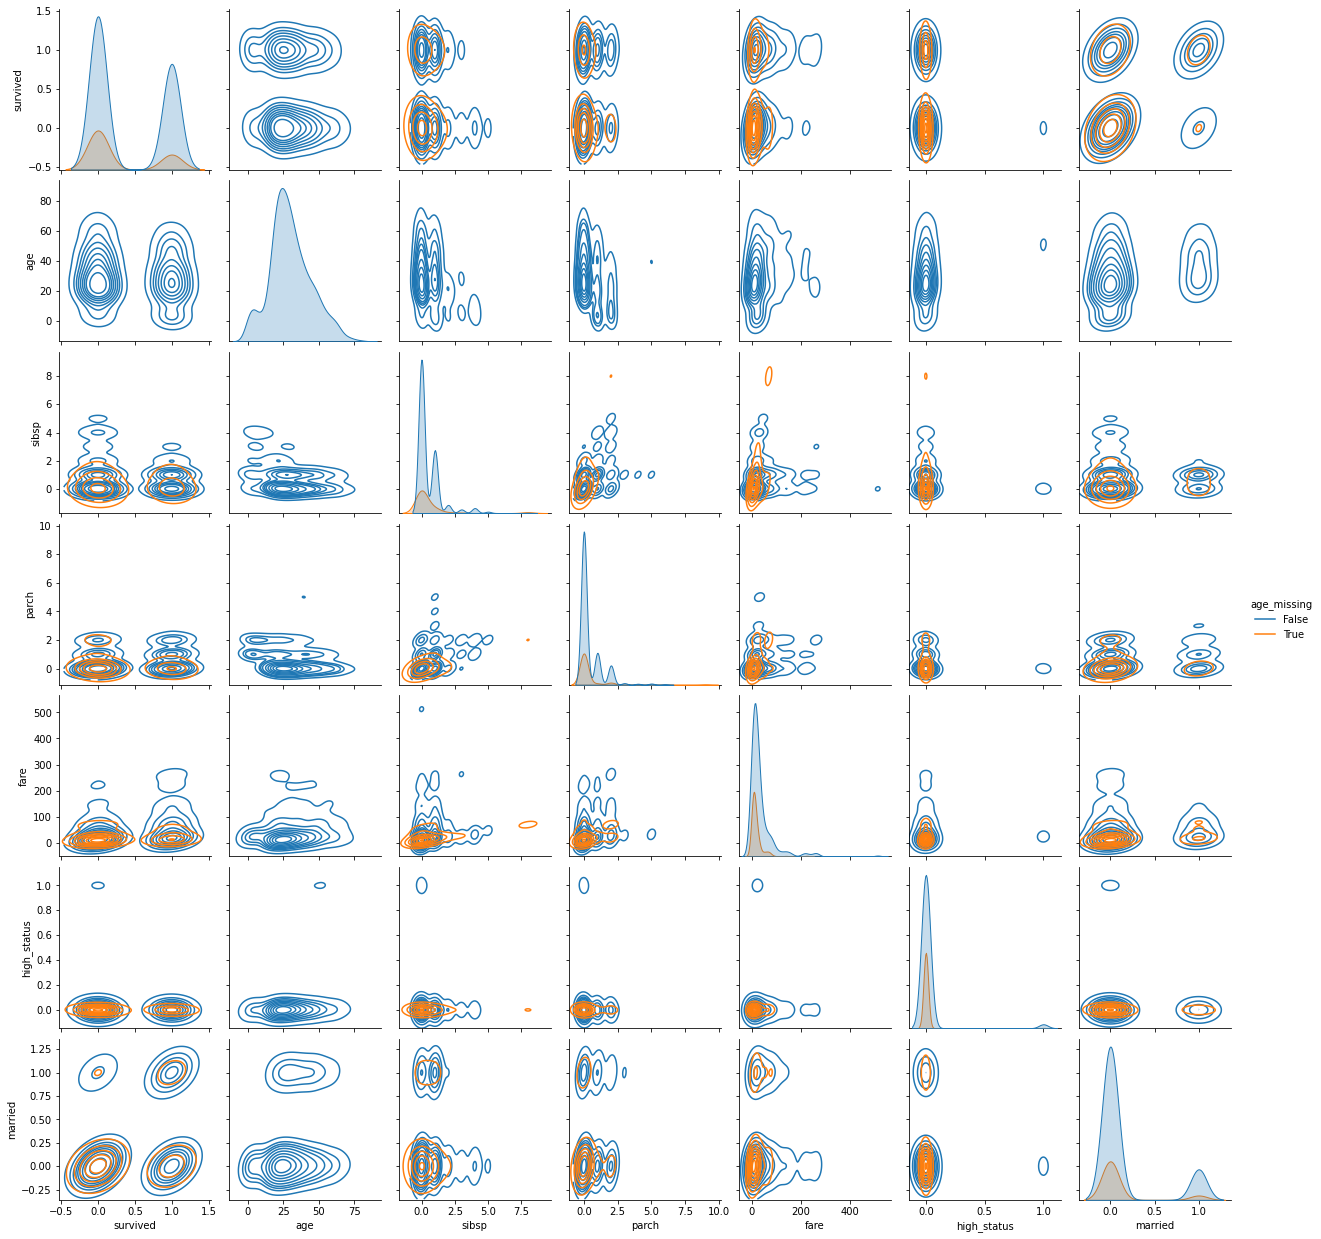

In [25]:
df['age_missing'] = np.where(df['age'].isna(), True, False)
sns.pairplot(df, hue='age_missing', kind='kde')

> missing age does not seem to be correlated with anything **except** sbsp (number of siblings and spouses) and parch (number of parents and children) - those may have been young children

In [26]:
df.loc[df['age'].isna(), 'sibsp'].value_counts()

0.0    206
1.0     39
8.0      8
2.0      6
3.0      4
Name: sibsp, dtype: int64

In [27]:
df.drop(columns=['age_missing'], inplace=True)

> correction - age is mostly missing with people who had no parents/siblings (and mostly did not survive - **not random -> use MICE imputation**

In [28]:
df['sex'] = np.where(df['sex'] == 'female', 1, 0)

> one-hot encoding the embarkation columns (drop 1?)

In [29]:
df = pd.concat([df, pd.get_dummies(df['embarked'], prefix='embarked')], axis=1)
df.drop(columns=['embarked'], inplace=True)

In [30]:
df['survived'] = df['survived'].astype(int)

In [31]:
imputer = IterativeImputer(min_value=0)
imputer.fit_transform(df)

df = pd.DataFrame(data=imputer.fit_transform(df), columns=df.columns)

In [32]:
# df = pd.DataFrame(data=mice(df.values), columns=df.columns)
# old imputation w. different package

<AxesSubplot:>

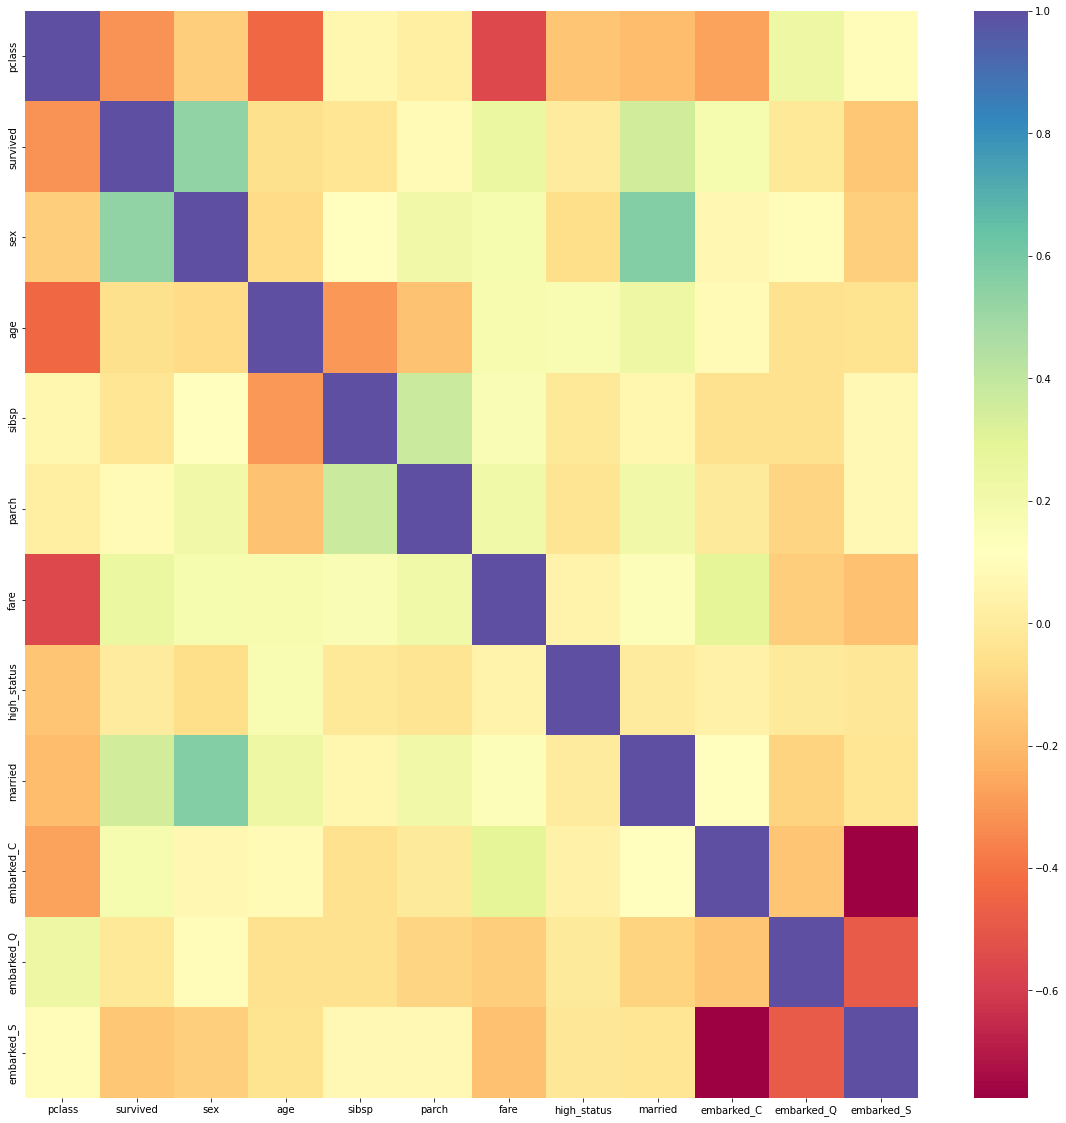

In [33]:
plt.figure(figsize=(20, 20))
sns.heatmap(df.corr(), cmap='Spectral')

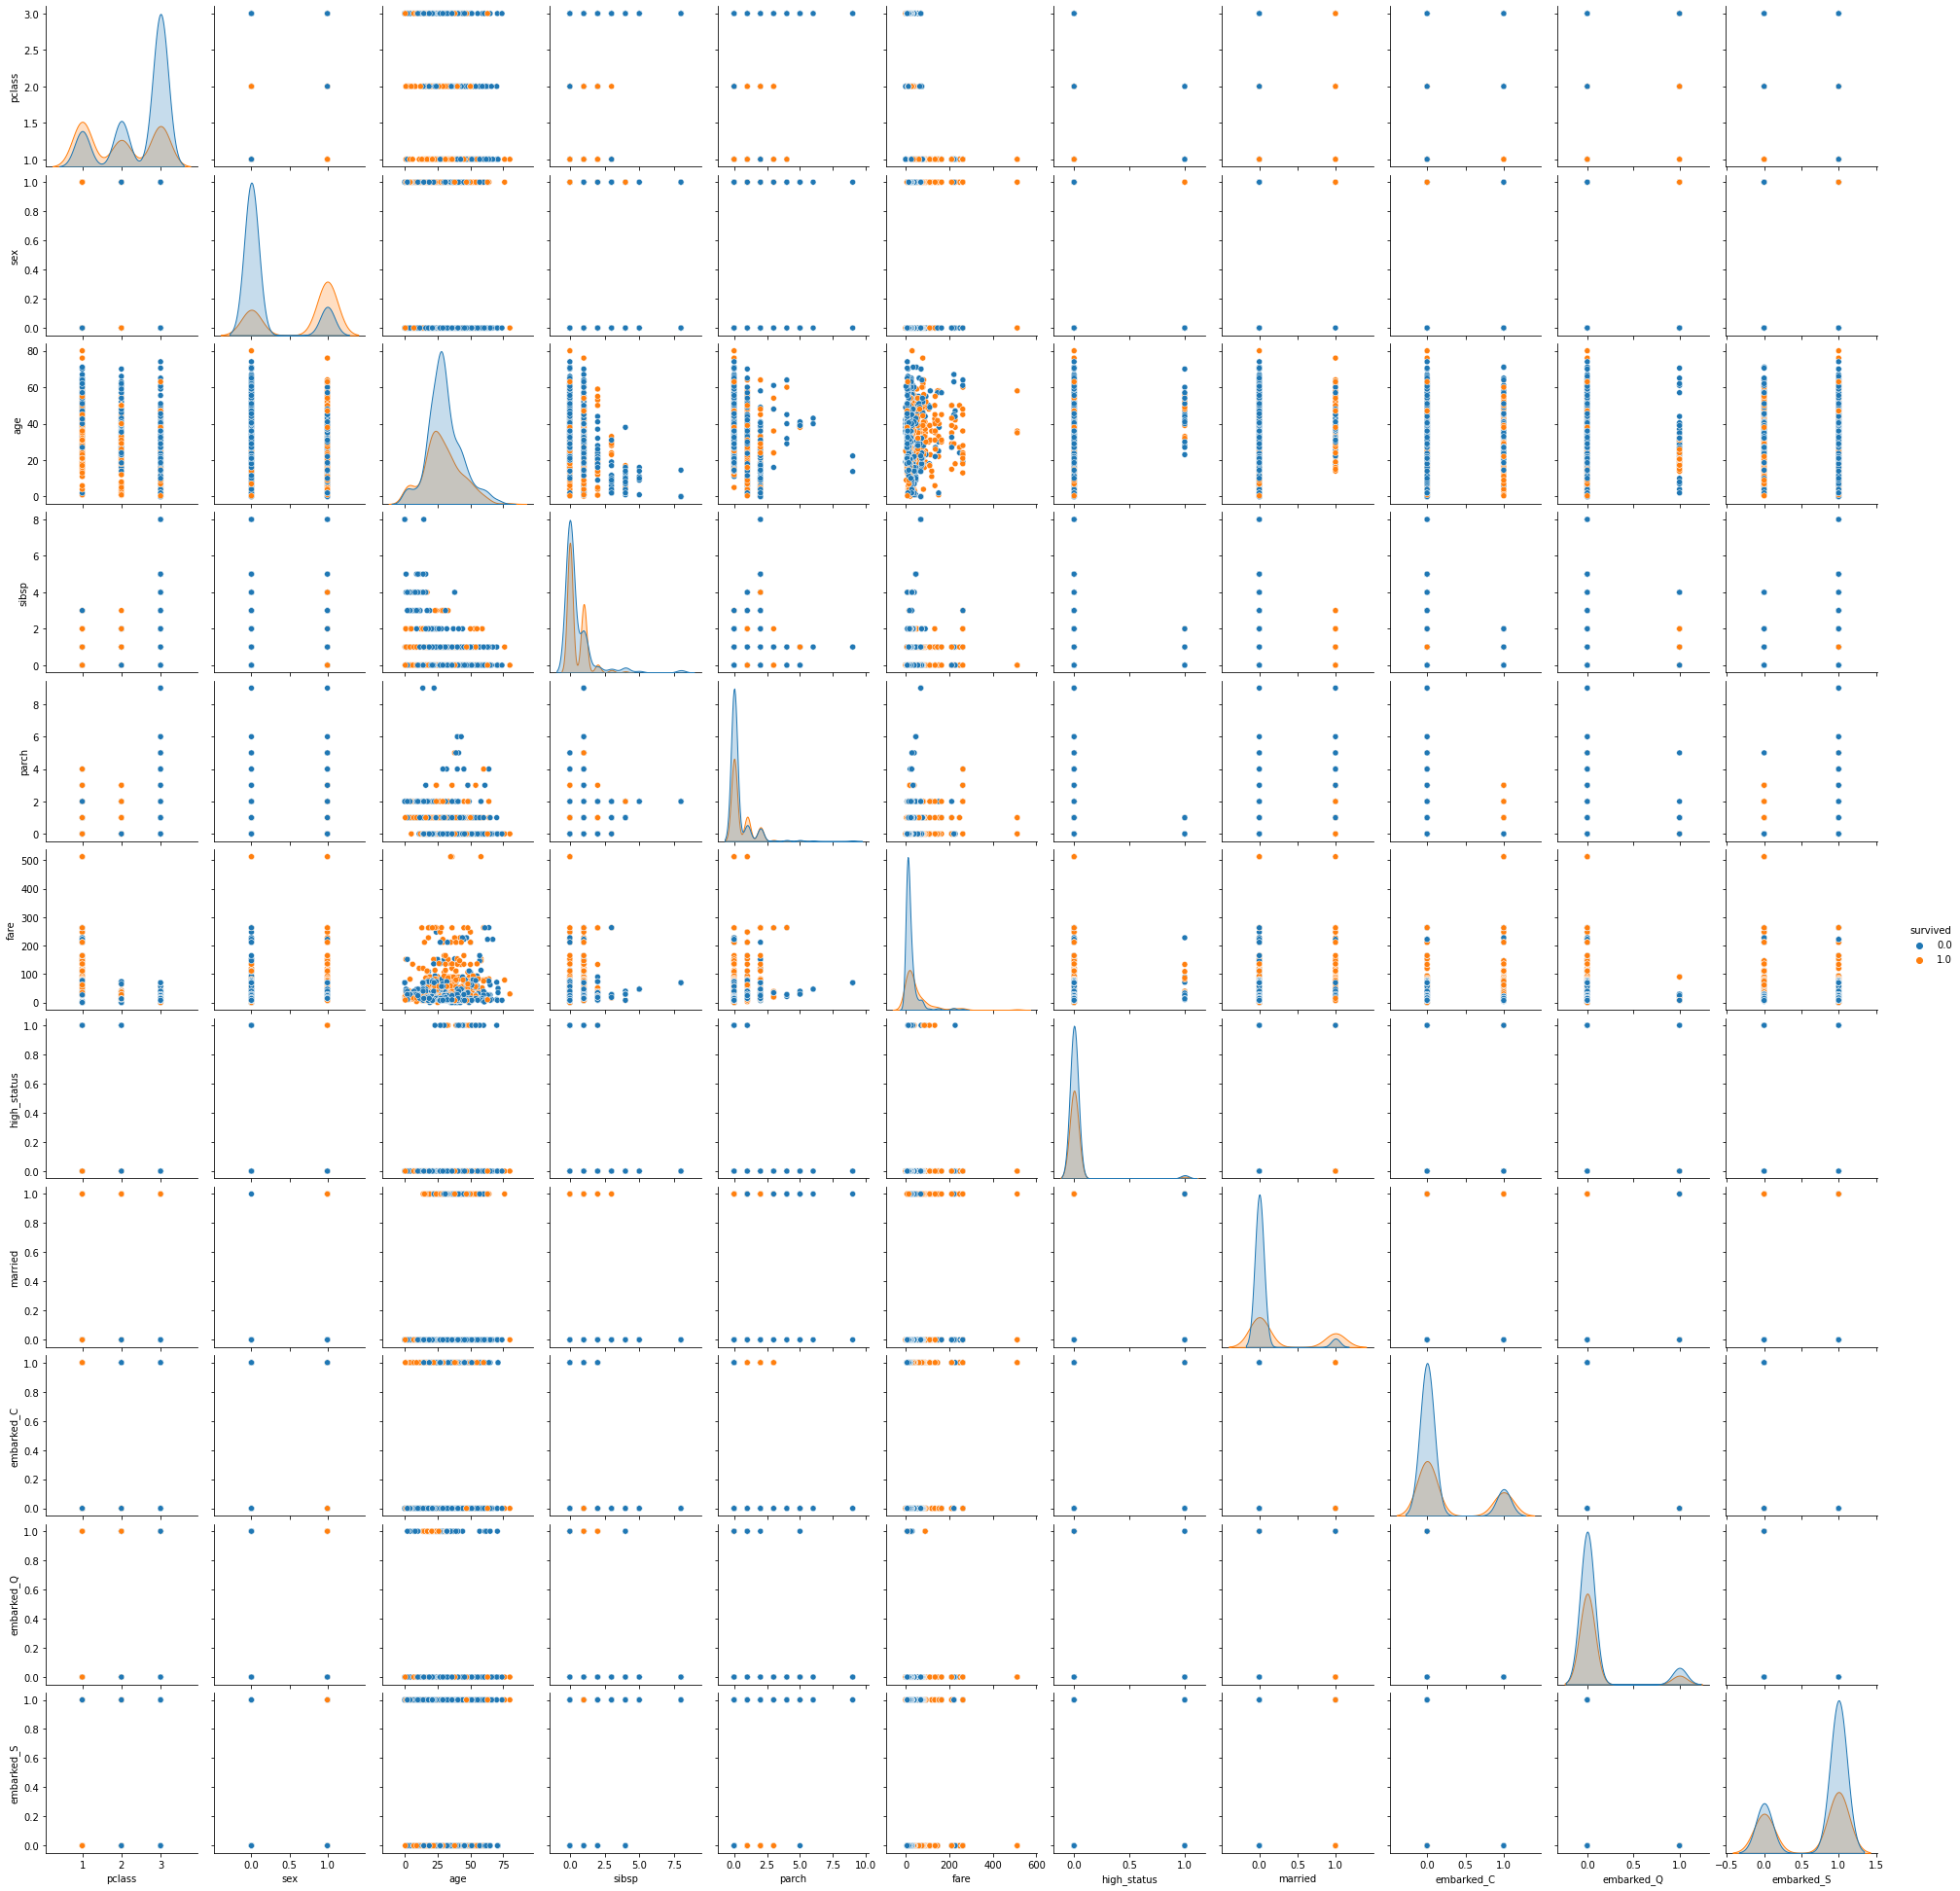

In [34]:
sns.pairplot(df, hue='survived')

### scaling

> check distributions, values that are normally distributed will be normally scaled, all others min-max

In [36]:
df.describe()

,pclass,survived,sex,age,sibsp,parch,fare,high_status,married,embarked_C,embarked_Q,embarked_S
count,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,2.294882,0.381971,0.355997,29.519526,0.498854,0.385027,33.271559,0.020626,0.153552,0.206264,0.093965,0.698243
std,0.837836,0.486055,0.478997,13.481537,1.041658,0.865560,51.746117,0.142184,0.360657,0.404777,0.291891,0.459196
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,21.000000,0.000000,0.000000,7.895800,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,0.000000,0.000000,28.406068,0.000000,0.000000,14.454200,0.000000,0.000000,0.000000,0.000000,1.000000
75%,3.000000,1.000000,1.000000,36.345037,1.000000,0.000000,31.275000,0.000000,0.000000,0.000000,0.000000,1.000000
max,3.000000,1.000000,1.000000,80.000000,8.000000,9.000000,512.329200,1.000000,1.000000,1.000000,1.000000,1.000000


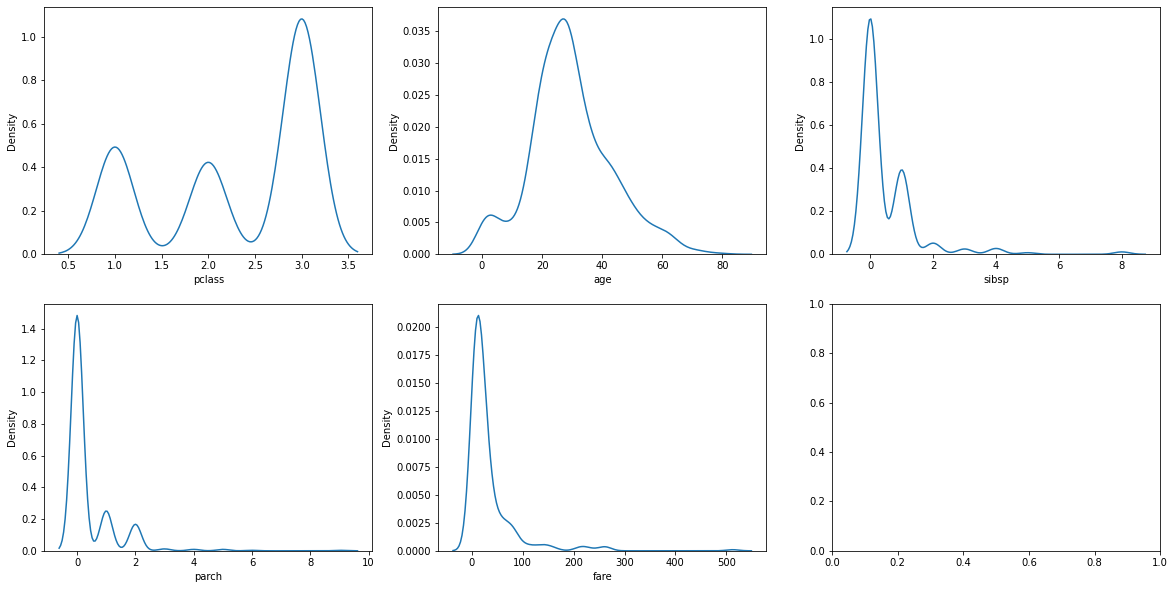

In [46]:
to_scale = ['pclass', 'age', 'sibsp', 'parch', 'fare']

plt.rc('figure', figsize=(20, 10))
fig, axes = plt.subplots(ncols = 3, nrows = 2)

for i, ax in zip(to_scale, axes.flat):
    sns.kdeplot(df[i], ax=ax)

### pretty clear that only age is normally distributed -- scale all others min-max

In [56]:
for i in to_scale:
    if i == 'age':
        scaler = StandardScaler()
    else:
        scaler = MinMaxScaler()
    
    df[i] = scaler.fit_transform(df[[i]])

In [57]:
df.describe()

,pclass,survived,sex,age,sibsp,parch,fare,high_status,married,embarked_C,embarked_Q,embarked_S
count,1309.000000,1309.000000,1309.000000,1.309000e+03,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,0.647441,0.381971,0.355997,-8.685014e-17,0.062357,0.042781,0.064942,0.020626,0.153552,0.206264,0.093965,0.698243
std,0.418918,0.486055,0.478997,1.000382e+00,0.130207,0.096173,0.101002,0.142184,0.360657,0.404777,0.291891,0.459196
min,0.000000,0.000000,0.000000,-2.190463e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.500000,0.000000,0.000000,-6.321817e-01,0.000000,0.000000,0.015412,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,-8.262286e-02,0.000000,0.000000,0.028213,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,1.000000,1.000000,5.064793e-01,0.125000,0.000000,0.061045,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,3.745846e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## basic classifiers using sklearn